# Gradient descent - longer run
Created 19/05/2024

Objectives:
* Still struggling to see convergence... fix hyperparameters but run for longer.

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../")

In [3]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import time

from collections import namedtuple

In [4]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt

In [5]:
from SPTOptimization.utils import (
    to_npc_array
)

from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.Optimizers.MPOGradientDescent import (
    MPOGradientDescent
)

# Load data

In [6]:
DATA_DIR_2 = r"../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [7]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [8]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

# Definitons

In [9]:
MAX_VIRTUAL_BOND_DIM = 30
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
# MPO bond dim?
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

Define bosonic symmetries. Label by the group element added.

In [10]:
np_00 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

np_01 = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

np_11 = np.array([
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
])

In [11]:
bosonic_np_symmetries = [
    np_00,
    np_01,
    np_10,
    np_11
]

In [12]:
bosonic_npc_symmetries = [
    to_npc_array(X) for X in bosonic_np_symmetries
]

In [13]:
npc_00 = to_npc_array(np_00)
npc_01 = to_npc_array(np_01)
npc_10 = to_npc_array(np_10)
npc_11 = to_npc_array(np_11)

Define "fermionic symmetries". Just identity and JW string.

In [14]:
np_I = np.array([
    [1, 0],
    [0, 1]
])

np_JW = np.array([
    [1, 0],
    [0, -1]
])

In [15]:
fermionic_np_symmetries = [np_I, np_JW]

In [16]:
fermionic_npc_symmetries = [
    to_npc_array(X) for X in fermionic_np_symmetries
]

In [17]:
npc_JW = fermionic_npc_symmetries[1]

In [18]:
symmetry_actions = [
    [[b, f] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [19]:
shifted_symmetry_actions = [
    [[f, b] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [20]:
cases_non_triv_proj_rep = dict()
psi = loaded_data_non_triv_proj_rep[0]

for i, l in enumerate(symmetry_actions):

    for j, s in enumerate(l):
        case = SymmetryActionWithBoundaryUnitaries(
            psi,
            s*40,
            left_symmetry_index=60,
            left_boundary_unitaries=[np_I, np_00]*1,
            right_boundary_unitaries=[np_00, np_I]*1
        )

        cases_non_triv_proj_rep[(i, j)] = case

In [21]:
for c in cases_non_triv_proj_rep.values():
    c.compute_svd_approximate_expectation()

In [22]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 8) and (overlap > 0.9):
        return True
    return False

In [23]:
def get_diverging_sol(unitarity, overlap):
    if unitarity > 1e10:
        return True
    if overlap > 1e10:
        return True
    return False

# Get MPO solutions

## Attempt 1

In [32]:
num_sites = 5

unitarity_learning_rate = 1
overlap_learning_rate = 30

num_iterations = int(1e4)
bond_dimension = 6

In [25]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [26]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 10) and (overlap > 0.9):
        return True
    return False

In [27]:
adam_params = (1e-3, 0.4, 0.4)

In [29]:
test_case = cases_non_triv_proj_rep[(0,1)]

In [33]:
opt = MPOGradientDescent(
    test_case,
    num_sites,
    bond_dimension,
    unitarity_learning_rate,
    1,
    overlap_learning_rate,
    adam_params,
    random_initial_mpo=True
)

for i in range(num_iterations):
    opt.grad_desc_one_step()

    if (i%100 == 0):
        print(i)
        print(opt.unitarity_scores[-1])
        print(opt.mpo_expectations[-1])

0
254.01286617095062
1.2737114650132946e-06
100
121.02625327536134
0.00021026544175421983
200
1.7167391239299832
6.917310553392136e-05
300
0.14615703483099196
1.63130624637063e-05
400
0.07079412406213237
1.4773360037560687e-05
500
0.051224105356368455
8.751835944686238e-06
600
0.045127734114771556
8.646950161927619e-06
700
0.043934639718486324
1.1899802186622934e-05
800
0.05264870532744226
9.810697405889485e-06
900
0.05222950623868883
1.1211370128874598e-05
1000
0.05125617909405378
1.341237854242228e-05
1100
0.03556553866360446
1.1204397787777196e-05
1200
0.016968419069911533
1.3620048550246397e-05
1300
0.013448393232408762
1.2814625722392978e-05
1400
0.019574684631777473
1.2726180524687907e-05
1500
0.026364527266423465
6.2546866210303256e-06
1600
0.04409009749809911
1.157850541768864e-05
1700
0.030937521267617285
1.082128527655382e-05
1800
0.01007459093932539
1.1041409766104579e-05
1900
0.008490298575395627
9.464750644277613e-06
2000
0.007554588927064287
1.179239406292028e-05
2100
0.0

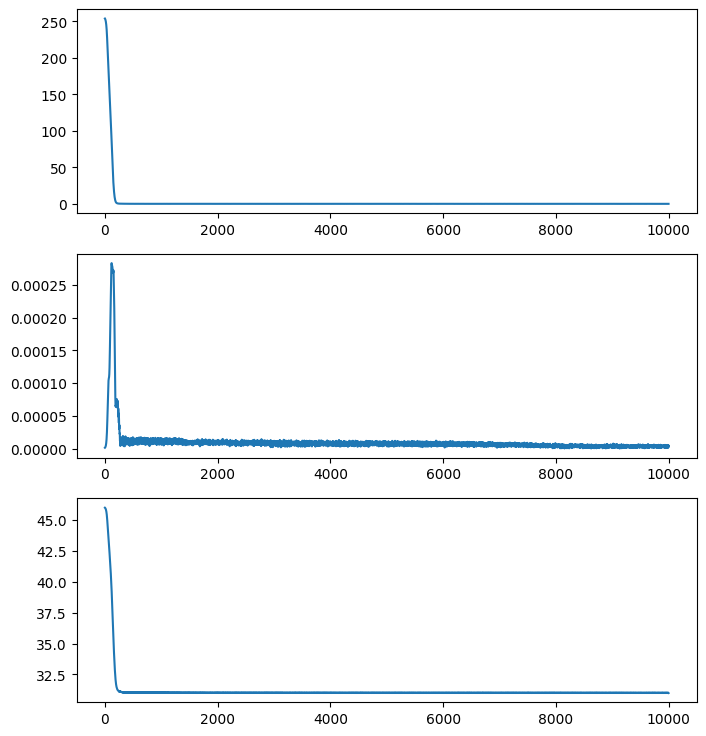

In [35]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))

ax1.plot(opt.unitarity_scores)
ax2.plot(opt.mpo_expectations)
opt.compute_training_losses()
ax3.plot(opt.training_losses)

## Attempt 2

In [36]:
num_sites = 5

unitarity_learning_rate = 1
overlap_learning_rate = 60

num_iterations = int(1e4)
bond_dimension = 6

In [37]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [38]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 10) and (overlap > 0.9):
        return True
    return False

In [39]:
adam_params = (1e-3, 0.4, 0.4)

In [40]:
test_case = cases_non_triv_proj_rep[(0,1)]

In [41]:
opt = MPOGradientDescent(
    test_case,
    num_sites,
    bond_dimension,
    unitarity_learning_rate,
    1,
    overlap_learning_rate,
    adam_params,
    random_initial_mpo=True
)

for i in range(num_iterations):
    opt.grad_desc_one_step()

    if (i%100 == 0):
        print(i)
        print(opt.unitarity_scores[-1])
        print(opt.mpo_expectations[-1])

0
254.01397629900387
1.0570677469405692e-06
100
122.65145218508633
0.0001784696978460293
200
5.900505356977646
8.105285156858714e-05
300
0.18689367863183293
9.079197896260113e-05
400
0.07071545545522895
0.0001552396973709545
500
0.07112030150290138
0.0002760764009268623
600
0.0653151944873116
0.0004555097396123399
700
0.06764455518748491
0.0006774854540403735
800
0.0645779135677742
0.0007417567490278724
900
0.0578393744797836
0.0008370521842013234
1000
0.0398498250948478
0.0008666285930190241
1100
0.027950695976898032
0.0011787450060662332
1200
0.04715790020327404
0.0007447394337637992
1300
0.023073940397239312
0.0004390051246464784
1400
0.023702237822021743
0.0003600076131954961
1500
0.01979459275250406
0.00030571705381611395
1600
0.022303831974625155
0.00036302829612034585
1700
0.019848239479671292
0.00030155542463626095
1800
0.0232877782682408
0.00034078687293142315
1900
0.017502292825014365
0.00039098048987907256
2000
0.010629488380459406
0.0003664534029920966
2100
0.00849597029946

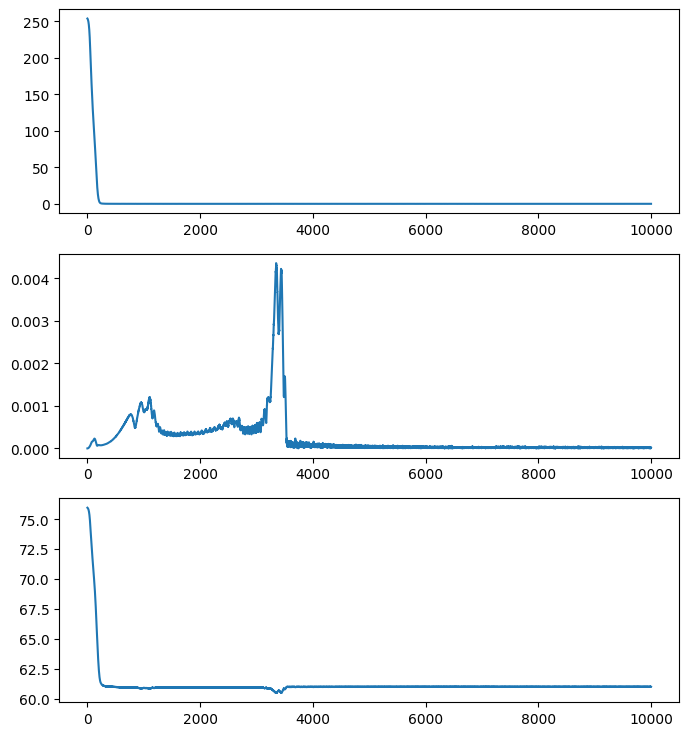

In [42]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))

ax1.plot(opt.unitarity_scores)
ax2.plot(opt.mpo_expectations)
opt.compute_training_losses()
ax3.plot(opt.training_losses)

Wait, what's happening at the dip? Something is wrong...

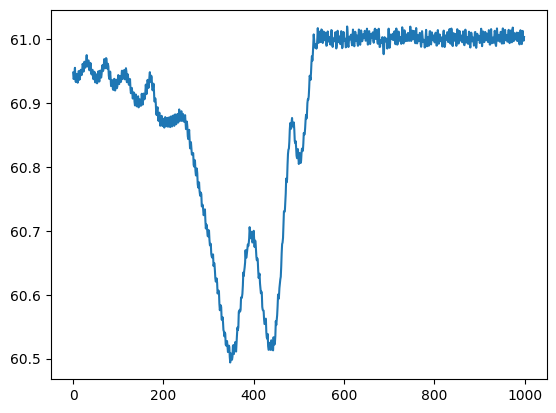

In [44]:
plt.plot(opt.training_losses[3000:4000])

This is _not_ the expected behaviour...! Could be an artifact of momentum...?

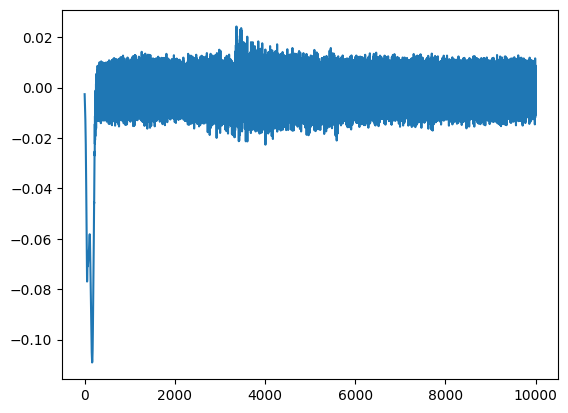

In [43]:
plt.plot(opt.training_losses[1:] - opt.training_losses[:-1])